In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import json
import numpy as np
import pandas as pd
import string
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
import sys
import seaborn
from sklearn import preprocessing
#import lightgbm as lgb 

In [2]:
millionsub = pd.read_csv('data/million_song_subset.csv')
msdset = pd.read_csv('data/msdset.csv')

hot100 = pd.read_csv('data/hot-100.csv')
albumcat = pd.read_csv('data/catalog-albums.csv')
songsale = pd.read_csv('data/digital-song-sales.csv')
popsongs = pd.read_csv('data/pop-songs.csv')
radiosongs = pd.read_csv('data/radio-songs.csv')
streamingsongs = pd.read_csv('data/streaming-songs.csv')
topabsale = pd.read_csv('data/top-album-sales.csv')
youtubesongs = pd.read_csv('data/youtube.csv')

In [26]:
msdset[(msdset.song_hotness>0) & (msdset.post_year>0)][['song_hotness','post_year']]

,song_hotness,post_year
1,0.262309,1997
20,0.561309,1982
26,0.215080,1993
28,0.610642,2007
32,0.450184,2004
34,0.710586,1996
41,0.645448,2008
42,0.212045,1998
45,0.706510,2008
47,0.428702,2004


Text(0,0.5,'hotness')

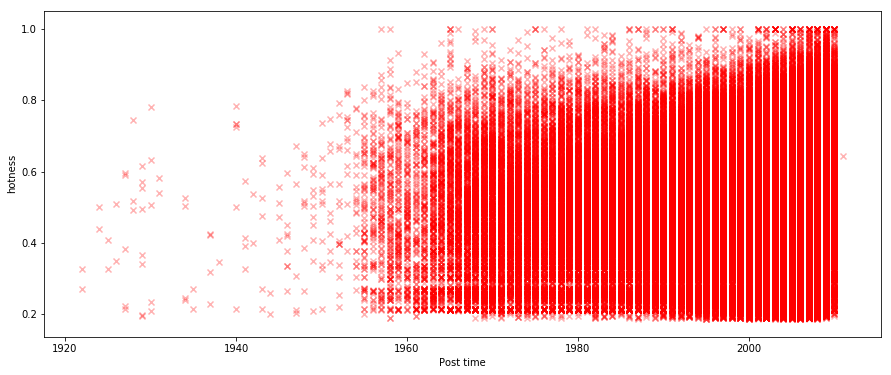

In [30]:
fig = plt.figure(figsize = (15,6))
plt.scatter(msdset[(msdset.song_hotness>0) & (msdset.post_year>0)]['post_year'],
            msdset[(msdset.song_hotness>0) & (msdset.post_year>0)]['song_hotness'],marker='x', c='r', alpha=0.3)
plt.xlabel('Post time')
plt.ylabel('hotness')

In [18]:
postyeardf = msdset[msdset['post_year']>0][['post_year', 'artist_name', 'title']]
t=postyeardf.groupby(['artist_name','title'])['post_year'].count()
t[t>1]

artist_name                                   title                                       
'Til Tuesday                                  Love In A Vacuum                                2
                                              The Other End (Of The Telescope)                2
                                              Voices Carry                                    2
                                              Why Must I                                      2
+44                                           Baby Come On                                    2
                                              Cliff Diving                                    2
                                              Lycanthrope                                     2
                                              Weatherman                                      2
                                              When Your Heart Stops Beating                   5
-123min.                                     

In [20]:
t[t>1].describe()

count    32170.000000
mean         2.441778
std          1.198705
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         87.000000
Name: post_year, dtype: float64

In [21]:
hot100

,title,chart_date,artist_name,peak_rank,last_rank,on_chart_weeks,current_rank,is_new
0,Girls Like You,2018-11-10,Maroon 5 Featuring Cardi B,1,1,23,1,False
1,Sicko Mode,2018-11-10,Travis Scott,2,2,13,2,False
2,Happier,2018-11-10,Marshmello & Bastille,3,4,11,3,False
3,Lucid Dreams,2018-11-10,Juice WRLD,2,3,25,4,False
4,Better Now,2018-11-10,Post Malone,3,5,27,5,False
5,ZEZE,2018-11-10,Kodak Black Featuring Travis Scott & Offset,2,6,3,6,False
6,Youngblood,2018-11-10,5 Seconds Of Summer,7,7,22,7,False
7,Drip Too Hard,2018-11-10,Lil Baby & Gunna,4,8,7,8,False
8,Without Me,2018-11-10,Halsey,9,12,4,9,False
9,Mo Bamba,2018-11-10,Sheck Wes,10,16,10,10,False


In [4]:
sniff = hot100[['title','chart_date','artist_name']]


In [5]:
last_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).max()
first_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).min()

In [6]:
lifespan=pd.DataFrame({'first_time':first_time,'last_time':last_time})
lifespan['first_time']=pd.to_datetime(lifespan['first_time'],format='%Y-%m-%d')
lifespan['last_time']=pd.to_datetime(lifespan['last_time'],format='%Y-%m-%d')

In [7]:
lifespan['dayspan']=(lifespan['last_time']-lifespan['first_time']).dt.days

In [8]:
lifespan['yearspan']=lifespan['dayspan']/365.25

In [9]:
lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

,,first_time,last_time,dayspan,yearspan
title,artist_name,,,,
Jingle Bell Rock,Bobby Helms,1958-12-22,2018-01-03,21562,59.033539
The Christmas Song (Merry Christmas To You),Nat King Cole,1960-12-12,2018-01-06,20844,57.067762
Rockin' Around The Christmas Tree,Brenda Lee,1960-12-12,2018-01-06,20844,57.067762
Space Oddity,David Bowie,1973-01-27,2016-01-30,15708,43.006160
Thriller,Michael Jackson,1984-02-11,2018-11-10,12691,34.746064
Under Pressure,Queen & David Bowie,1981-11-07,2016-01-30,12502,34.228611
1999,Prince,1982-10-30,2016-05-14,12250,33.538672
Little Red Corvette,Prince,1983-02-26,2016-05-14,12131,33.212868
Careless Whisper,Wham! Featuring George Michael,1984-12-22,2017-01-14,11711,32.062971


(array([2.7577e+04, 1.4400e+02, 2.7000e+01, 1.4000e+01, 1.3000e+01,
        8.0000e+00, 5.0000e+00, 7.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.98389231,  1.96778462,  2.95167693,  3.93556924,
         4.91946156,  5.90335387,  6.88724618,  7.87113849,  8.8550308 ,
         9.83892311, 10.82281542, 11

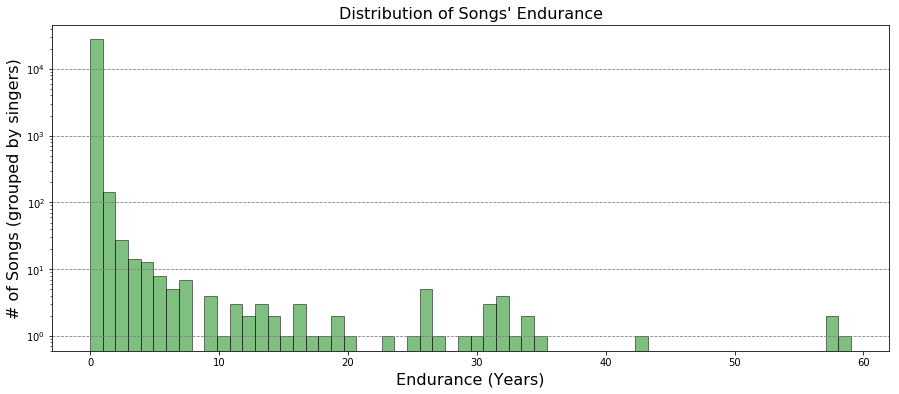

In [10]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs (grouped by singers)', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(lifespan['yearspan'], bins=60,facecolor="green", edgecolor="black", log=True, alpha=0.5)

In [11]:
song_last_time = sniff['chart_date'].groupby([sniff['title']]).max()
song_first_time = sniff['chart_date'].groupby([sniff['title']]).min()

In [12]:
song_lifespan=pd.DataFrame({'first_time':song_first_time,'last_time':song_last_time})
song_lifespan['first_time']=pd.to_datetime(song_lifespan['first_time'],format='%Y-%m-%d')
song_lifespan['last_time']=pd.to_datetime(song_lifespan['last_time'],format='%Y-%m-%d')

In [13]:
song_lifespan['dayspan']=(song_lifespan['last_time']-song_lifespan['first_time']).dt.days

In [14]:
song_lifespan['yearspan']=song_lifespan['dayspan']/365.25

In [15]:
song_lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

,first_time,last_time,dayspan,yearspan
title,,,,
Problems,1958-11-10,2018-10-13,21887,59.923340
Midnight,1958-08-11,2018-03-24,21775,59.616701
Mona Lisa,1959-06-01,2018-11-10,21712,59.444216
High Hopes,1959-06-15,2018-11-10,21698,59.405886
Try Me,1958-12-15,2018-04-21,21677,59.348392
Plain Jane,1959-01-26,2018-03-24,21607,59.156742
Talk To Me,1959-10-19,2018-11-10,21572,59.060917
Jingle Bell Rock,1958-12-22,2018-01-03,21562,59.033539
Paris,1958-10-20,2017-06-17,21425,58.658453


(array([2.0382e+04, 2.2400e+02, 1.4900e+02, 1.2000e+02, 1.1500e+02,
        8.2000e+01, 8.4000e+01, 8.4000e+01, 7.9000e+01, 8.0000e+01,
        5.5000e+01, 7.1000e+01, 8.2000e+01, 6.9000e+01, 7.0000e+01,
        6.1000e+01, 5.7000e+01, 6.2000e+01, 6.2000e+01, 6.5000e+01,
        6.1000e+01, 5.8000e+01, 3.9000e+01, 5.0000e+01, 3.8000e+01,
        4.0000e+01, 3.3000e+01, 4.9000e+01, 4.2000e+01, 4.3000e+01,
        4.1000e+01, 3.3000e+01, 3.1000e+01, 3.9000e+01, 3.0000e+01,
        2.4000e+01, 3.4000e+01, 2.4000e+01, 2.4000e+01, 2.6000e+01,
        2.1000e+01, 1.9000e+01, 2.6000e+01, 2.9000e+01, 2.1000e+01,
        2.2000e+01, 1.9000e+01, 2.6000e+01, 1.6000e+01, 2.0000e+01,
        1.3000e+01, 1.1000e+01, 1.3000e+01, 1.0000e+01, 1.1000e+01,
        1.5000e+01, 7.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00]),
 array([ 0.        ,  0.99872234,  1.99744467,  2.99616701,  3.99488935,
         4.99361168,  5.99233402,  6.99105635,  7.98977869,  8.98850103,
         9.98722336, 10.9859457 , 11

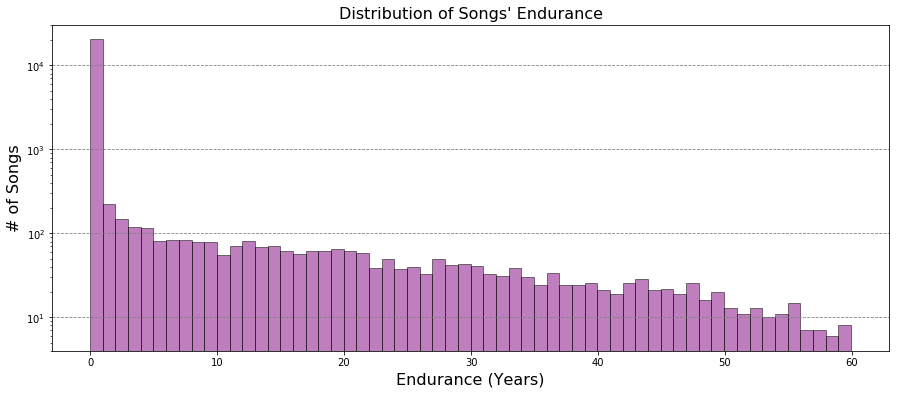

In [16]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(song_lifespan['yearspan'], bins=60,facecolor="purple", edgecolor="black", log=True, alpha=0.5)

In [17]:
singer_sniff = hot100[['chart_date','artist_name']]

In [18]:
singer_last_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).max()
singer_first_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).min()

In [19]:
singer_lifespan=pd.DataFrame({'first_time':singer_first_time,'last_time':singer_last_time})
singer_lifespan['first_time']=pd.to_datetime(singer_lifespan['first_time'],format='%Y-%m-%d')
singer_lifespan['last_time']=pd.to_datetime(singer_lifespan['last_time'],format='%Y-%m-%d')

In [20]:
singer_lifespan['dayspan']=(singer_lifespan['last_time']-singer_lifespan['first_time']).dt.days

In [21]:
singer_lifespan['yearspan']=singer_lifespan['dayspan']/365.25

In [22]:
singer_lifespan.sort_values(by=['dayspan'], ascending=False).head(20)

,first_time,last_time,dayspan,yearspan
artist_name,,,,
Nat King Cole,1958-08-11,2018-01-06,21698,59.405886
Bobby Helms,1958-08-18,2018-01-03,21688,59.378508
Andy Williams,1958-09-01,2018-01-06,21677,59.348392
Brenda Lee,1959-12-21,2018-01-06,21201,58.045175
Burl Ives,1961-12-18,2018-01-06,20473,56.052019
Glen Campbell,1961-10-30,2014-11-01,19360,53.004791
Jose Feliciano,1968-07-27,2018-01-03,18057,49.437372
Michael Jackson,1971-10-30,2018-11-10,17178,47.030801
Elvis Presley,1958-11-03,2003-10-04,16406,44.917180


(array([6.793e+03, 5.650e+02, 3.590e+02, 2.920e+02, 2.280e+02, 1.650e+02,
        1.560e+02, 1.160e+02, 9.800e+01, 7.600e+01, 8.400e+01, 6.100e+01,
        6.100e+01, 4.400e+01, 3.600e+01, 3.600e+01, 3.300e+01, 2.800e+01,
        2.300e+01, 2.200e+01, 1.800e+01, 1.700e+01, 8.000e+00, 1.000e+01,
        8.000e+00, 4.000e+00, 8.000e+00, 8.000e+00, 3.000e+00, 4.000e+00,
        5.000e+00, 7.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([ 0.        ,  0.99009811,  1.98019621,  2.97029432,  3.96039243,
         4.95049053,  5.94058864,  6.93068674,  7.92078485,  8.91088296,
         9.90098106, 10.89107917, 11.88117728, 12.87127538, 13.86137349,
        14.85147159, 15.8415697 , 16.83

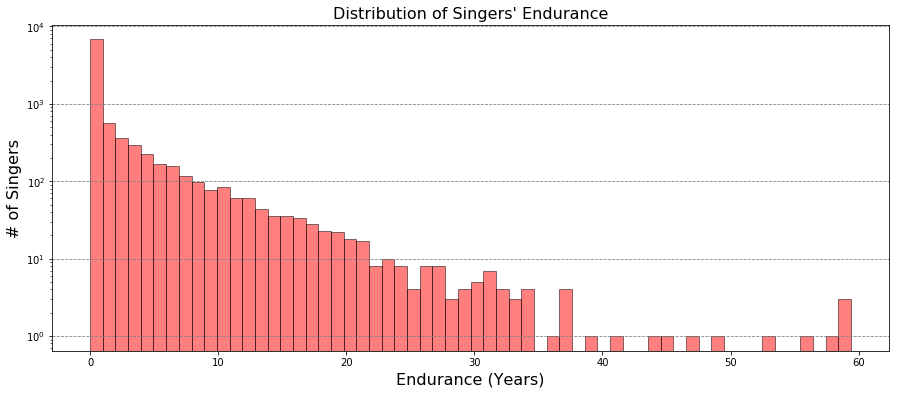

In [23]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Singers', size=16)
ax1.set_title('Distribution of Singers\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(singer_lifespan['yearspan'], bins=60,facecolor="red", edgecolor="black", log=True, alpha=0.5)

In [27]:
lifespan

,,first_time,last_time,dayspan,yearspan
title,artist_name,,,,
"""B"" Girls",Young And Restless,1990-05-05,1990-08-11,98,0.268309
"""Cherry Cherry"" from Hot August Night",Neil Diamond,1973-03-17,1973-05-19,63,0.172485
"""Having A Party"" Medley",The Ovations (Featuring Louis Williams),1973-10-13,1973-12-08,56,0.153320
"""Joy"" Pt. I",Isaac Hayes,1973-12-22,1974-02-16,56,0.153320
"""Roots"" Medley",Quincy Jones,1977-03-05,1977-04-16,42,0.114990
"""Yep!""",Duane Eddy His Twangy Guitar And The Rebels,1959-03-30,1959-05-25,56,0.153320
#1,Nelly,2001-10-20,2002-03-02,133,0.364134
#1 Dee Jay,Goody Goody,1978-11-18,1978-12-16,28,0.076660
#9 Dream,John Lennon,1974-12-21,1975-03-08,77,0.210815


In [40]:
sniff.sort_values(axis=0,by=['title','chart_date'])

,title,chart_date
148983,"""B"" Girls",1990-05-05
148877,"""B"" Girls",1990-05-12
148767,"""B"" Girls",1990-05-19
148659,"""B"" Girls",1990-05-26
148557,"""B"" Girls",1990-06-02
148454,"""B"" Girls",1990-06-09
148353,"""B"" Girls",1990-06-16
148256,"""B"" Girls",1990-06-23
148166,"""B"" Girls",1990-06-30
148074,"""B"" Girls",1990-07-07


In [3]:
sniff = hot100[['title','chart_date','artist_name']]


In [4]:
last_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).max()
first_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).min()

In [5]:
lifespan=pd.DataFrame({'first_time':first_time,'last_time':last_time})
lifespan['first_time']=pd.to_datetime(lifespan['first_time'],format='%Y-%m-%d')
lifespan['last_time']=pd.to_datetime(lifespan['last_time'],format='%Y-%m-%d')

In [6]:
lifespan['dayspan']=(lifespan['last_time']-lifespan['first_time']).dt.days

In [7]:
lifespan['yearspan']=lifespan['dayspan']/365.25

In [8]:
lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

,,first_time,last_time,dayspan,yearspan
title,artist_name,,,,
Jingle Bell Rock,Bobby Helms,1958-12-22,2018-01-03,21562,59.033539
The Christmas Song (Merry Christmas To You),Nat King Cole,1960-12-12,2018-01-06,20844,57.067762
Rockin' Around The Christmas Tree,Brenda Lee,1960-12-12,2018-01-06,20844,57.067762
Space Oddity,David Bowie,1973-01-27,2016-01-30,15708,43.006160
Thriller,Michael Jackson,1984-02-11,2018-11-10,12691,34.746064
Under Pressure,Queen & David Bowie,1981-11-07,2016-01-30,12502,34.228611
1999,Prince,1982-10-30,2016-05-14,12250,33.538672
Little Red Corvette,Prince,1983-02-26,2016-05-14,12131,33.212868
Careless Whisper,Wham! Featuring George Michael,1984-12-22,2017-01-14,11711,32.062971


In [10]:
chart_count = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).count()

In [11]:
score_frame=pd.DataFrame({'first_time':first_time,'chart_count':chart_count})

In [12]:
score_frame['first_time']=pd.to_datetime(score_frame['first_time'],format='%Y-%m-%d')
score_frame['first_time']=score_frame['first_time'].dt.year

In [13]:
score_frame['age']=2018-score_frame['first_time']

In [14]:
score_frame['score2018']=np.e**(0.003*score_frame['chart_count']/(1+score_frame['age']))

In [15]:
score_frame.sort_values(by='score2018', ascending=False)

,,first_time,chart_count,age,score2018
title,artist_name,,,,
The Middle,"Zedd, Maren Morris & Grey",2018,40,0,1.127497
I Like Me Better,Lauv,2018,38,0,1.120752
Love Lies,Khalid & Normani,2018,37,0,1.117395
God's Plan,Drake,2018,36,0,1.114048
Psycho,Post Malone Featuring Ty Dolla $ign,2018,36,0,1.114048
Sad!,XXXTENTACION,2018,35,0,1.110711
Tequila,Dan + Shay,2018,34,0,1.107383
Delicate,Taylor Swift,2018,34,0,1.107383
Mine,Bazzi,2018,34,0,1.107383


In [16]:
sniff['chart_year']=pd.to_datetime(sniff['chart_date'],format='%Y-%m-%d').dt.year

/Users/motianchi/anaconda3/envs/CSE519HW2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
for y in range(1958, 2019):
    temp = sniff[sniff['chart_year']<=y]
    cnt = temp['chart_date'].groupby([temp['title'], temp['artist_name']]).count()
    ft = temp['chart_date'].groupby([temp['title'], temp['artist_name']]).min()
    ages = y - pd.to_datetime(ft,format='%Y-%m-%d').dt.year
    scores = np.e**(0.003*cnt/(1+ages))
    score_frame['score'+str(y)]=scores

In [23]:
score_frame.fillna(0, inplace=True)

In [35]:
y1=[]
y2=[]
y3=[]
for y in range(1958, 2019):
    y1.append(score_frame.loc['Jingle Bell Rock','Bobby Helms']['score'+str(y)])
    y3.append(score_frame.loc['Billy Bayou', 'Jim Reeves']['score'+str(y)]) 
    
for y in range(1973, 2019):
    y2.append(score_frame.loc['Space Oddity', 'David Bowie']['score'+str(y)])

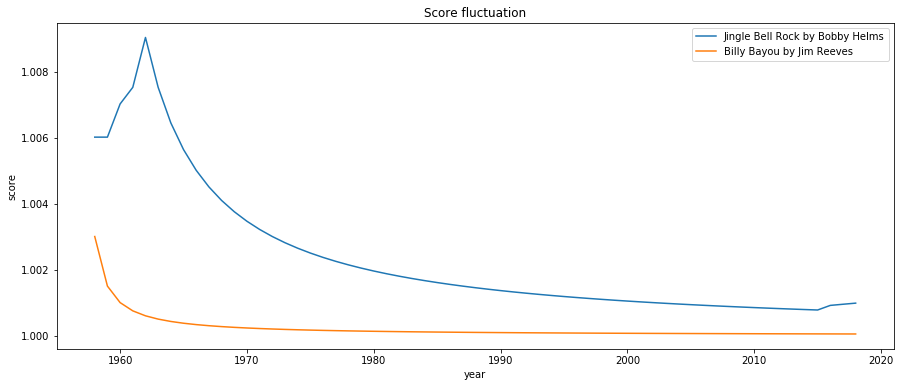

In [36]:
fig = plt.figure(figsize = (15,6))
plt.plot(range(1958, 2019), y1, label='Jingle Bell Rock by Bobby Helms')
plt.plot(range(1958, 2019), y3, label='Billy Bayou by Jim Reeves')

plt.title('Score fluctuation')
plt.xlabel('year')
plt.ylabel('score')
plt.legend()
plt.show()

In [34]:
score_frame[score_frame.first_time==1958]['chart_count']

title                                             artist_name                   
(All of a Sudden) My Heart Sings                  Paul Anka                         18
(I Wanna) Dance With The Teacher                  The Olympics                       5
16 Candles                                        The Crests                        22
A Certain Smile                                   Johnny Mathis                      8
A House, A Car And A Wedding Ring                 Dale Hawkins                       5
                                                  Mike Preston                       1
A Letter To An Angel                              Jimmy Clanton                     12
A Lover's Question                                Clyde McPhatter                   25
A Part Of Me                                      Jimmy Clanton                      7
All I Have To Do Is Dream                         The Everly Brothers                3
All Over Again                                   

In [7]:
hot100

,title,chart_date,artist_name,peak_rank,last_rank,on_chart_weeks,current_rank,is_new
0,Girls Like You,2018-11-10,Maroon 5 Featuring Cardi B,1,1,23,1,False
1,Sicko Mode,2018-11-10,Travis Scott,2,2,13,2,False
2,Happier,2018-11-10,Marshmello & Bastille,3,4,11,3,False
3,Lucid Dreams,2018-11-10,Juice WRLD,2,3,25,4,False
4,Better Now,2018-11-10,Post Malone,3,5,27,5,False
5,ZEZE,2018-11-10,Kodak Black Featuring Travis Scott & Offset,2,6,3,6,False
6,Youngblood,2018-11-10,5 Seconds Of Summer,7,7,22,7,False
7,Drip Too Hard,2018-11-10,Lil Baby & Gunna,4,8,7,8,False
8,Without Me,2018-11-10,Halsey,9,12,4,9,False
9,Mo Bamba,2018-11-10,Sheck Wes,10,16,10,10,False


In [10]:
sniff = hot100[['title','chart_date','artist_name','current_rank']]


In [12]:
last = sniff.groupby([sniff['title'], sniff['artist_name']]).apply(lambda t: t[t.chart_date==t.chart_date.max()])
first = sniff.groupby([sniff['title'], sniff['artist_name']]).apply(lambda t: t[t.chart_date==t.chart_date.min()])

In [16]:
last

,,,title,chart_date,artist_name,current_rank
title,artist_name,,,,,
"""B"" Girls",Young And Restless,147590,"""B"" Girls",1990-08-11,Young And Restless,91
"""Cherry Cherry"" from Hot August Night",Neil Diamond,237450,"""Cherry Cherry"" from Hot August Night",1973-05-19,Neil Diamond,51
"""Having A Party"" Medley",The Ovations (Featuring Louis Williams),234561,"""Having A Party"" Medley",1973-12-08,The Ovations (Featuring Louis Williams),62
"""Joy"" Pt. I",Isaac Hayes,233541,"""Joy"" Pt. I",1974-02-16,Isaac Hayes,42
"""Roots"" Medley",Quincy Jones,217082,"""Roots"" Medley",1977-04-16,Quincy Jones,83
"""Yep!""",Duane Eddy His Twangy Guitar And The Rebels,310377,"""Yep!""",1959-05-25,Duane Eddy His Twangy Guitar And The Rebels,78
#1,Nelly,87271,#1,2002-03-02,Nelly,72
#1 Dee Jay,Goody Goody,208398,#1 Dee Jay,1978-12-16,Goody Goody,99
#9 Dream,John Lennon,228046,#9 Dream,1975-03-08,John Lennon,47


In [17]:
last_date = last['chart_date'].groupby([last['title'], last['artist_name']]).max()
last_rank = last['current_rank'].groupby([last['title'], last['artist_name']]).max()

In [18]:
first_date = first['chart_date'].groupby([first['title'], first['artist_name']]).min()
first_rank = first['current_rank'].groupby([first['title'], first['artist_name']]).min()

In [20]:
bl=pd.DataFrame({'last_date':last_date,'last_rank':last_rank,'first_date':first_date,'first_rank':first_rank})
bl['first_date']=pd.to_datetime(bl['first_date'],format='%Y-%m-%d')
bl['last_date']=pd.to_datetime(bl['last_date'],format='%Y-%m-%d')

In [32]:
bl['d_week']=np.e**(0.003*(bl['last_date']-bl['first_date']).dt.days/7)

In [34]:
x=bl[['first_rank','d_week']]
y=bl['last_rank']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [36]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [41]:
y_predict=clf.predict(X_test)

In [42]:
error=y_predict-y_test

In [43]:
error=error**2


In [47]:
msre=np.sqrt(error.sum()/6961)

In [48]:
print(msre)

21.365648787833717
